In [1]:
import os
from collections import defaultdict

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import teotil2 as teo
from rasterstats import zonal_stats

plt.style.use("ggplot")

In [2]:
# Connect to db
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


# TEOTIL2 Metals

## Part 2: The 2019 "1000 Lakes" dataset

Poor statistical relationships and incomplete datasets make it difficult to use the moss and geochemistry datasets to derive export coefficient and retention factors for TEOTIL2 Metals (see previous notebook). However, the 2019 1000 Lakes survey provides a detailed picture of the **spatial distribution of metal concentrations in Norwegian freshwaters**. To some extent, this dataset can be used to bypass the challenges with the moss and geochemistry data: since we already know the concentration in surface waters, it is not necessary to allow for retention (i.e. we can assume retention is 0 if we use metal concentrations directly from the 1000 Lakes survey); it is also no longer necessary to derive export coefficients from the "geology" and "depositon" datasets, since we have direct estimates of metal concentrations in the water.

The downside of this approach is that it is no longer possible to distinguish between inputs from bedrock weathering and those from atmospheric deposition. This is unfortunate, as one of the main benefits of models such as TEOTIL is the ability to perform "source apportionment" i.e. to separate total fluxes into several contributing components. Nevertheless, in this case I do not think this will be a major problem, since we must already assume geochemical concentrations are constant (because there there is only one geochemical survey dataset, from 1984/5). Whichever approach is chosen (mosses + geochemistry versus water chemistry), the geochemical contribution will therefore be approximately constant (except for minor changes relating to hydrology, which can be accounted for by both methods). 

In other words, rather than attempting to separate the bedrock weathering and atmospheric depositon components using dubious statistical relationships, it may be better to instead estimate the combined (weathering + deposition) component directly from the water chemistry data, but then further assume that any changes in this component are driven primarily by changing atmospheric depositon, rather than bedrock weathering. This simultaneously solves the twin problems of estimating retention factors and export coefficients, and the core assumption that changes in deposition dominate changes in bedrock weathering is probably also reasonable over annual or decadal time scales. Finally, although this approach is slighly different to the conceptualisation of nutrients in TEOTIL2, it is identical to the way the model estimates catchment-level water fluxes i.e. this approach is compatible with the basic structure of a TEOTIL model.

This notebook aims to:

 1. Identify which lakes in the 2019 1000 Lakes survey are not influenced by point discharges upstream i.e. identify the lakes where observed metal concentrations can be assumed to be primarily influenced by bedrock weathering and atmospheric deposition
 
 2. Spatially interpolate the data from just these lakes onto a common grid
 
 3. Use zonal statistics to estimate the average concentration of each metal in each regine subcatchment
 
 4. Use this information to build a simple TEOTIL2 model for metals in 2019, and compare output from this model to fluxes calculated from observations as part of the annual Elveovervåkingprogrammet
 
 5. Compare performance of the model to the "default" historic method of simply summing all point discharges

## 1. Read point discharge data

In [3]:
# Read pt data
pt_csv = f"../data/metals/point_discharges/regine_pt_dis_metals_1990-2019.csv"
pt_df = pd.read_csv(pt_csv)
del pt_df["unit"]
pt_df.set_index(["regine", "type", "year", "name"], inplace=True)
pt_df = pt_df.unstack("name")
pt_df.columns = pt_df.columns.get_level_values(1)
pt_df = pt_df.unstack("type")
pt_df.columns = [("_".join(col).rstrip("_")).lower() for col in pt_df.columns.values]
pt_df.reset_index(inplace=True)

pt_df.head()

,regine,year,as_industri,as_renseanlegg,cd_industri,cd_renseanlegg,cr_industri,cr_renseanlegg,cu_industri,cu_renseanlegg,hg_industri,hg_renseanlegg,ni_industri,ni_renseanlegg,pb_industri,pb_renseanlegg,zn_industri,zn_renseanlegg
0,001.22Z,1992,NaN,NaN,NaN,NaN,NaN,NaN,0.000029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000018,NaN
1,001.22Z,1993,NaN,NaN,NaN,NaN,NaN,NaN,0.000053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000035,NaN
2,001.22Z,1994,NaN,NaN,NaN,NaN,NaN,NaN,0.000110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000024,NaN
3,001.22Z,1995,NaN,NaN,NaN,NaN,NaN,NaN,0.000020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000020,NaN
4,001.22Z,1996,NaN,NaN,NaN,NaN,NaN,NaN,0.000030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000020,NaN


In [4]:
# Indicator column for catchments with any point inputs in 1990 - 2019
pt_df["ones"] = 1
pt_df = pt_df[["regine", "ones"]].drop_duplicates()

## 2. Build catchment network and accumulate

The code below identifies all regine catchments with *at least one* industry or renseanlegg site somewhere upstream.

In [5]:
# Read basic net data
net_csv = r"../data/core_input_data/regine_2018_onwards.csv"
net_df = pd.read_csv(net_csv, sep=";")
net_df = net_df[["regine", "regine_ned"]]
assert net_df["regine"].is_unique

# Add info on pt inputs
net_df = pd.merge(net_df, pt_df, how="left", on="regine")
net_df["ones"].fillna(0, inplace=True)

# Build graph
g = nx.DiGraph()

# Add nodes
for idx, row in net_df.iterrows():
    nd = row["regine"]
    g.add_node(nd, local=row.to_dict(), accum={})

# Add edges
for idx, row in net_df.iterrows():
    fr_nd = row["regine"]
    to_nd = row["regine_ned"]
    g.add_edge(fr_nd, to_nd)

# Check directed tree
assert nx.is_tree(g), "g is not a valid tree."
assert nx.is_directed_acyclic_graph(g), "g is not a valid DAG."

In [6]:
# Accumulate 'ones' downstream
# Process nodes in topo order from headwaters down
for nd in list(nx.topological_sort(g))[:-1]:
    # Get catchments directly upstream
    preds = list(g.predecessors(nd))

    if len(preds) > 0:
        # Accumulate total input from upstream
        # Counters default to 0
        tot_dict = defaultdict(int)

        # Loop over upstream catchments
        for pred in preds:
            tot_dict["ones"] += g.nodes[pred]["accum"]["ones"]

        # Assign outputs
        g.nodes[nd]["accum"]["ones"] = g.nodes[nd]["local"]["ones"] + tot_dict["ones"]

    else:
        g.nodes[nd]["accum"]["ones"] = g.nodes[nd]["local"]["ones"]

In [7]:
# Get all regine catchments with one or more point inputs somewhere upstream
up_pt_df = teo.model_to_dataframe(g)
up_pt_df = up_pt_df.query("accum_ones > 0")

## 3. Read 1000 lakes data for 2019

The code in this section identifies the 1000 Lakes stations with **no point inputs anywhere upstream**. These are assumed to be influenced only by "diffuse" inputs - primarily bedrock weathering and atmospheric deposition.

In [8]:
k_df = pd.read_csv(r"../data/metals/1k_lakes/1k_lakes_2019_metals_toc_ph.csv")
del k_df["station_id"], k_df["station_name"]

k_stn_df = pd.read_csv(r"../data/metals/1k_lakes/1k_stations.csv")
k_stn_df.dropna(subset=["longitude", "latitude"], inplace=True)
del k_stn_df["name"]

k_df = pd.merge(k_stn_df, k_df, how="inner", on="station_code")
k_df.head()

,station_id,station_code,station_name,latitude,longitude,altitude,sample_date,As_µg/l,Cd_µg/l,Cr_µg/l,Cu_µg/l,Hg_ng/l,Ni_µg/l,Pb_µg/l,Zn_µg/l,TOC_mg C/l,pH_
0,3167,620-4-6,Ørteren,60.470,7.795,1147.0,2019-10-03,0.034,0.005,0.05,0.19,0.27,0.47,0.010,2.30,0.93,6.75
1,3168,621-1-27,Flåvatna,60.200,9.183,855.0,2019-10-23,0.130,0.006,0.18,0.12,2.67,0.26,0.086,1.70,8.30,6.72
2,3169,621-3-5,Soneren,60.061,9.545,104.0,2019-10-23,0.170,0.013,0.20,0.48,2.51,0.35,0.150,3.30,8.70,6.09
3,3170,622-2-43,Trytetjern,60.213,9.764,275.0,2019-10-23,0.180,0.015,0.28,0.47,3.31,0.62,0.130,4.00,10.50,5.99
4,3171,622-4-4,Krøderen,60.327,9.645,133.0,2019-10-23,0.086,0.004,0.05,0.40,1.08,0.28,0.031,0.93,3.00,6.77


In [9]:
# Read TEOTIL regine units
shp_path = "../data/gis/reg_minste_f_wgs84.shp"
reg_gdf = gpd.read_file(shp_path)
reg_gdf = reg_gdf.drop_duplicates(subset=["VASSDRAGNR"]).reset_index(drop=True)

# Assign 1000 Lakes sites to regines
k_stn_df = nivapy.spatial.identify_point_in_polygon(
    k_stn_df, reg_gdf, poly_col="VASSDRAGNR"
)
k_stn_df.rename({"VASSDRAGNR": "regine"}, inplace=True, axis="columns")

k_stn_df.head()

,station_id,station_code,station_name,latitude,longitude,altitude,regine
0,3167,620-4-6,Ørteren,60.470,7.795,1147.0,012.CHB
1,3168,621-1-27,Flåvatna,60.200,9.183,855.0,015.GAAZ
2,3169,621-3-5,Soneren,60.061,9.545,104.0,012.BB42
3,3170,622-2-43,Trytetjern,60.213,9.764,275.0,012.DBB
4,3171,622-4-4,Krøderen,60.327,9.645,133.0,012.CB6


In [10]:
# Get stations with no upstream points inputs
pt_stn_list = list(up_pt_df["regine"].unique())
k_stn_df = k_stn_df.query("regine not in @pt_stn_list")
print(
    len(k_stn_df), "stations in the 1000 Lakes dataset with no upstream point inputs."
)

nivapy.spatial.quickmap(k_stn_df, popup="station_code", cluster=True)

947 stations in the 1000 Lakes dataset with no upstream point inputs.


## 4. Interpolate 1000 Lakes dataset

Excluding stations with upstream point sources.

In [11]:
# Define co-ord system
crs = ccrs.AlbersEqualArea(
    central_longitude=15,
    central_latitude=65,
    false_easting=650000,
    false_northing=800000,
    standard_parallels=(55, 75),
)

# Set up grid
cell_size = 1000  # metres

# Extent
xmin = 0
xmax = 1300000
ymin = 0
ymax = 1600000
extent = [xmin, xmax, ymin, ymax]

# Set up grid for interpolation
# Shift by (cell_size/2) s.t. values are estimated for the centre of each grid square
gridx = np.arange(xmin, xmax, cell_size) + (cell_size / 2.0)
gridy = np.arange(ymin, ymax, cell_size) + (cell_size / 2.0)

# Get Natural Earth data
land_50m = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_0_countries",
    scale="50m",
    edgecolor="black",
    facecolor=cfeature.COLORS["land"],
)

sea_50m = cfeature.NaturalEarthFeature(
    category="physical",
    name="ocean",
    scale="50m",
    edgecolor="none",
    facecolor=cfeature.COLORS["water"],
    alpha=1,
)

country_shp = cartopy.io.shapereader.natural_earth(
    resolution="50m", category="cultural", name="admin_0_countries"
)

In [12]:
# Get stations with no upstream point inputs
k_stn_list = list(k_stn_df["station_id"].unique())
k_df = k_df.query("station_id in @k_stn_list")

# Loop over pars and interpolate
par_list = ["As", "Cd", "Cr", "Cu", "Hg", "Ni", "Pb", "Zn"]
for par in par_list:
    print(f"Processing: {par}")

    if par == "Hg":
        unit = "ng/l"
    else:
        unit = "µg/l"

    df = k_df[["latitude", "longitude", f"{par}_{unit}"]].dropna(how="any")

    # Map (long, lat) to projected (x, y) and reformat to syntax required
    # by interp algorithms
    pts = crs.transform_points(
        src_crs=ccrs.PlateCarree(), x=df["longitude"].values, y=df["latitude"].values
    )[:, :2]

    # Get values to interpolate
    vals = df[f"{par}_{unit}"].values

    # IDW interpolation
    idw = nivapy.spatial.interp_idw(pts, vals, gridx, gridy, n_near=20, p=1)

    # Save output
    unit = unit.replace("/", "p")
    idw_path = (
        f"../data/metals/1k_lakes/1klakes_2019_{par.lower()}_{unit}_idw_n20_p1.tif"
    )
    nivapy.spatial.array_to_gtiff(
        xmin,
        ymax,
        cell_size,
        idw_path,
        idw,
        crs.proj4_init,
        no_data_value=-9999,
        bit_depth="Float32",
    )

Processing: As
Processing: Cd
Processing: Cr
Processing: Cu
Processing: Hg
Processing: Ni
Processing: Pb
Processing: Zn


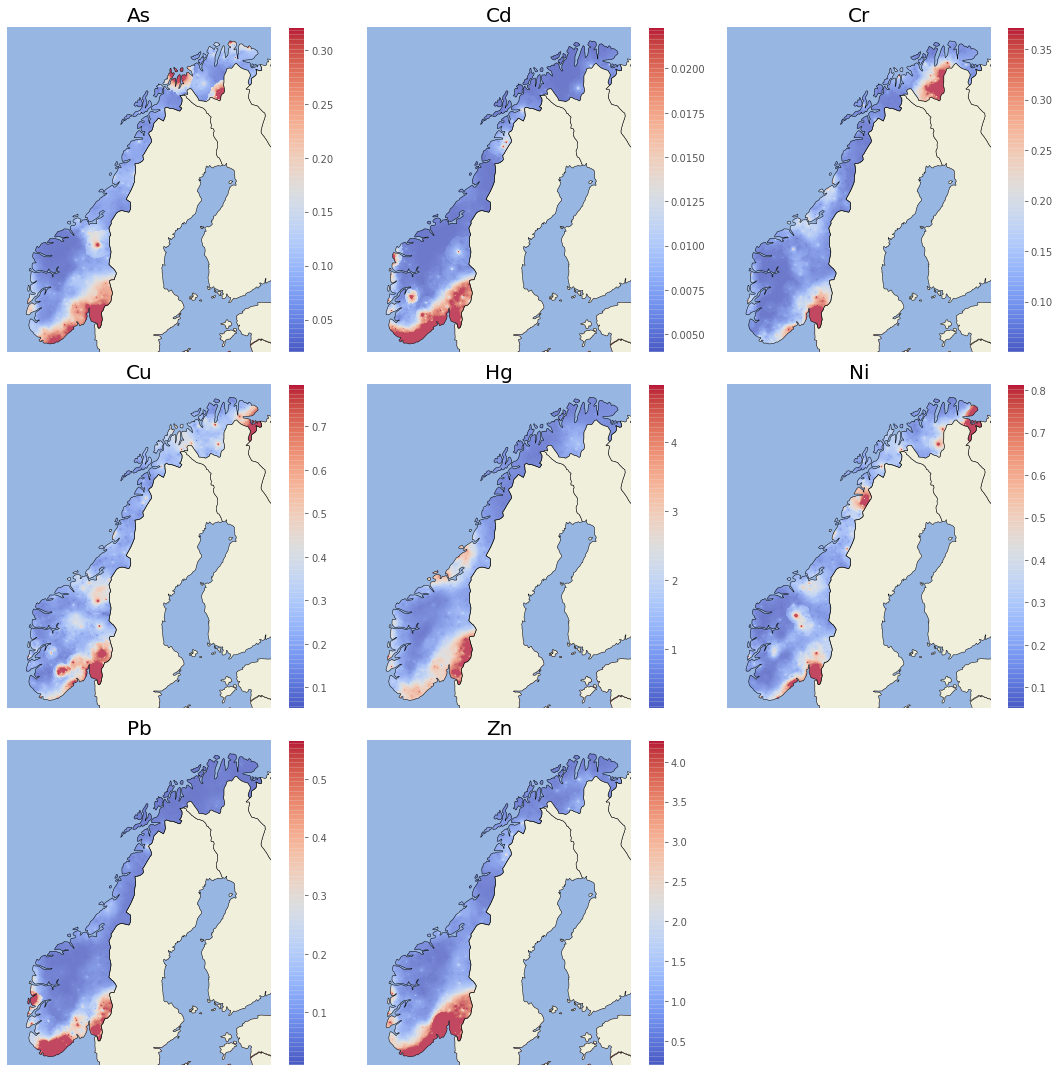

In [13]:
# Setup fig
fig = plt.figure(figsize=(15, 15))

# Loop over data
par_list = ["As", "Cd", "Cr", "Cu", "Hg", "Ni", "Pb", "Zn"]
for idx, par in enumerate(par_list):
    if par == "Hg":
        unit = "ng/l"
    else:
        unit = "µg/l"
    unit = unit.replace("/", "p")

    # Read data
    gtiff_path = (
        f"../data/metals/1k_lakes/1klakes_2019_{par.lower()}_{unit}_idw_n20_p1.tif"
    )
    data = nivapy.spatial.read_raster(gtiff_path, band_no=1)[0]

    # Plot
    ax = fig.add_subplot(3, 3, idx + 1, projection=crs)
    ax.set_extent(extent, crs=crs)
    ax.set_title(par.capitalize(), fontsize=20)
    cax = ax.imshow(
        data,
        zorder=1,
        extent=extent,
        cmap="coolwarm",
        alpha=0.7,
        interpolation="none",
        vmax=np.nanpercentile(data, 95),
    )

    # Add colourbar
    cbar = fig.colorbar(cax)

    # Make Norway "hollow" so interpolated vaues are visible.
    # Make everywhere else opaque to mask wildly extrapolated values
    reader = cartopy.io.shapereader.Reader(country_shp)
    countries = reader.records()
    for country in countries:
        if country.attributes["NAME"] == "Norway":
            # Transparent
            ax.add_geometries(
                [country.geometry],
                ccrs.PlateCarree(),  # CRS of Natural Earth data
                facecolor="none",
                edgecolor="black",
                zorder=5,
            )
        else:
            # Opaque
            ax.add_geometries(
                [country.geometry],
                ccrs.PlateCarree(),  # CRS of Natural Earth data
                facecolor=cfeature.COLORS["land"],
                edgecolor="black",
                zorder=5,
            )

    # Add sea
    ax.add_feature(sea_50m, zorder=4)

plt.tight_layout()

# Save
out_path = f"../plots/metals/1k_lakes/1klakes_2019_idw_n20_p1.png"
plt.savefig(out_path, dpi=300)

## 7. Zonal statistics

Summarise the interpolated datasets across all regine catchments.

In [14]:
df_list = []
for par in par_list:
    print(f"Processing: {par}")

    if par == "Hg":
        unit = "ng/l"
    else:
        unit = "µg/l"
    unit = unit.replace("/", "p")

    ras_path = (
        f"../data/metals/1k_lakes/1klakes_2019_{par.lower()}_{unit}_idw_n20_p1.tif"
    )

    # Temporary nearest-neighbour resampling to 250 m (as some cacthments are so small that
    # they do not contain any cell centres at 1000 m)
    data = nivapy.spatial.read_raster(ras_path, band_no=1)[0]
    data = nivapy.spatial.rebin_array(data, 4)  # 1000 m to 250 m
    tmp_path = "temp_ras.tif"
    nivapy.spatial.array_to_gtiff(
        xmin,
        ymax,
        250,
        tmp_path,
        data,
        crs.proj4_init,
        no_data_value=-9999,
        bit_depth="Float32",
    )

    stats = zonal_stats(
        reg_gdf["geometry"].to_crs(crs.proj4_init), tmp_path, stats=["mean"]
    )
    stats = pd.DataFrame(stats)
    stats.rename({"mean": f"{par}_{unit}"}, inplace=True, axis="columns")
    df_list.append(stats)

    os.remove(tmp_path)

wc_stats = pd.concat(df_list, axis="columns")
wc_stats["regine"] = reg_gdf["VASSDRAGNR"]

# Save
out_csv = r"../data/metals/1k_lakes/regine_avg_water_concs_idw_n20_p1.csv"
wc_stats.to_csv(out_csv, index=False)

# Also save to "core" input folder
out_csv = r"../data/core_input_data/mean_metal_concs_2019.csv"
wc_stats.to_csv(out_csv, index=False)

wc_stats.head()

Processing: As
Processing: Cd
Processing: Cr
Processing: Cu
Processing: Hg
Processing: Ni
Processing: Pb
Processing: Zn


,As_µgpl,Cd_µgpl,Cr_µgpl,Cu_µgpl,Hg_ngpl,Ni_µgpl,Pb_µgpl,Zn_µgpl,regine
0,0.109857,0.013921,0.130599,0.202348,2.211361,0.126365,0.304175,2.420740,067.62
1,0.189877,0.019524,0.098083,0.317619,1.897942,0.196454,0.473340,3.067434,019.F211
2,0.025905,0.004637,0.050091,0.163377,0.434148,0.102739,0.023321,0.366312,077.1E
3,0.046234,0.004101,0.070965,0.274912,0.441536,0.260651,0.015020,0.335967,196.2A2A
4,0.054101,0.004129,0.063061,0.127131,0.672303,0.197753,0.046351,0.316140,152.2D2B3


## 8. Build and test TEOTIL2 model for metals in 2019

The CSV file created above has been imported into `../data/core_input_data/nope_core_rid_inputs.xlsx` and then exported again as `mean_metal_concs_2019.csv`. I have also created a file named `retention_metals.csv`, where the retention factor for all catchments is set to 0 (because retention should not be necessary if we're working directly with surface water concentrations). I have also added a function [here](https://github.com/NIVANorge/teotil2/blob/08ce0e97f859c101e064beff0bbbcc3621e54378/notebooks/teotil2.py#L1254) to automatically generate TEOTIL2 input files for metals based on these data. In summary, these files are constructed as follows:

 1. Discharge is estimated for each regine catchment by calculating change factors at the level of Norway's "main catchments" (based on data supplied annually by NVE) and applying these to long-term average runoff for each regine unit. This is identical to the approach taken by the original TEOTIL and TEOTIL2 (nutrients) models
 
 2. Diffuse-source metal concentrations for each regine catchment are inferred using the data calculated above (i.e. zonal summaries from the interpolated 2019 1000 Lakes dataset, using only lakes with no upstream point sources)
 
 3. Known point discharges are assigned to the relevant regine catchments, in exactly the same way as previously
 
 4. "Local" fluxes for each catchment are calculated as $concentration \times discharge$ and accumulated downstream. Retention for all catchments is assumed to be zero (see above)

### 8.1. Read observed fluxes for 20 "main rivers"

The fluxes below are calculated annually from observed data as part of Elveovervåkingsprogrammet and reported to OSPAR.

In [15]:
# Properties for RID 20 rivers
stn_xlsx = r"../data/metals/rid20_obs_loads/RID_Sites_List_2017-2020.xlsx"
stn_df = pd.read_excel(stn_xlsx, sheet_name="RID_20")
stn_df.head()

,station_id,station_code,station_name,old_rid_group,new_rid_group,ospar_region,station_type,nve_vassdrag_nr,lat,lon,utm_north,utm_east,utm_zone
0,30019,AAGEVEG,Vegårdselva,rid_108,rid_20,SKAGERAK,R,018.A322,58.669996,8.980983,6503307.0,498897.0,32
1,29612,BUSEDRA,Drammenselva,rid_11,rid_20,SKAGERAK,R,012.A3,59.753995,10.008990,6624446.0,556695.0,32
2,29779,FINEALT,Altaelva,rid_11,rid_20,LOFOTEN-BARENTS SEA,R,212.A0,69.900992,23.286977,7759686.0,586586.0,34
3,29819,FINEPAS,Pasvikelva,rid_36,rid_20,LOFOTEN-BARENTS SEA,R,246.A5,69.500996,30.115996,7712884.0,387322.0,36
4,29820,FINETAN,Tanaelva,rid_36,rid_20,LOFOTEN-BARENTS SEA,R,234.B41,70.229993,28.173988,7791949.0,544316.0,35


In [16]:
# Just the data for 2019
year = 2019
par_list = ["As", "Cd", "Cr", "Cu", "Hg", "Ni", "Pb", "Zn"]
data_fold = r"../data/core_input_data"

In [17]:
# Read obs data
obs_csv = f"../data/metals/rid20_obs_loads/rid20_obs_metals_1990-2019.csv"
obs_df = pd.read_csv(obs_csv, sep=";")
del obs_df["Ag_Est"], obs_df["Ag_tonnes"]

# Convert Hg to tonnes
obs_df.set_index(["station_id", "year"], inplace=True)
obs_df["Hg_kg"] = obs_df["Hg_kg"] / 1000
obs_df.rename({"Hg_kg": "Hg_tonnes"}, axis="columns", inplace=True)

# Use just "real" obserbations, not statistical estimates
for par in par_list:
    obs_df[f"{par}_tonnes"] = np.where(
        obs_df[f"{par}_Est"] == 1, np.nan, obs_df[f"{par}_tonnes"]
    )
    del obs_df[f"{par}_Est"]

# Convert to long format
obs_df.reset_index(inplace=True)
obs_df = obs_df.melt(id_vars=["station_id", "year"])
obs_df["variable"] = obs_df["variable"].str.lower()

# Join regine ID
obs_df = pd.merge(
    stn_df[["station_id", "nve_vassdrag_nr"]], obs_df, how="left", on="station_id"
)
obs_df.rename({"nve_vassdrag_nr": "regine"}, inplace=True, axis="columns")
obs_df.dropna(inplace=True)

# If all measured values are at the LOD, the OSPAR methodology estimates fluxes
# as zero, which is not realistic. Only include samples with data above the LOD
obs_df = obs_df.query("value > 0")

# Obs Hg for Glomma in 1998 is clearly wrong - see notebook dev04
obs_df = obs_df.query("~((regine == '002.A51') and (year == 1998) and (variable == 'hg_tonnes'))")

obs_df = obs_df.query("year == @year")

print(len(obs_df))

obs_df.head()

160


,station_id,regine,year,variable,value
29,30019,018.A322,2019,cd_tonnes,0.021842
59,30019,018.A322,2019,cu_tonnes,0.412278
89,30019,018.A322,2019,hg_tonnes,0.000785
119,30019,018.A322,2019,pb_tonnes,0.238372
149,30019,018.A322,2019,zn_tonnes,3.723882


### 8.2. Create TEOTIL2 input file

In [18]:
# Make input file
ann_csv = f"../data/norway_annual_input_data/metals_input_data_{year}.csv"
in_df = teo.make_input_file(
    year, eng, data_fold, ann_csv, mode="metals", par_list=par_list
)

in_df.head()

,regine,regine_ned,a_reg_km2,runoff_mm/yr,q_reg_m3/s,vol_lake_m3,ind_as_tonnes,ind_cd_tonnes,ind_cr_tonnes,ind_cu_tonnes,...,all_sources_pb_tonnes,all_sources_zn_tonnes,trans_as,trans_cd,trans_cr,trans_cu,trans_hg,trans_ni,trans_pb,trans_zn
0,001.,1_2,0.00,0.000000,0.000000,0.000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,001.10,001.,1.41,529.752684,0.023686,0.000,0.0,0.0,0.0,0.0,...,0.000615,0.004678,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,001.1A1,001.10,1.16,529.752684,0.019486,0.000,0.0,0.0,0.0,0.0,...,0.000507,0.003859,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,001.1A20,001.1A1,0.35,378.394774,0.004200,0.000,0.0,0.0,0.0,0.0,...,0.000112,0.000845,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,001.1A2A,001.1A20,17.40,454.073729,0.250535,1598010.258,0.0,0.0,0.0,0.0,...,0.006968,0.051519,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### 8.3. Run model

In [19]:
ann_csv = f"../data/norway_annual_input_data/metals_input_data_{year}.csv"
g = teo.run_model(ann_csv)
mod_df = teo.model_to_dataframe(g)

mod_df.head()

,regine,regine_ned,accum_all_point_as_tonnes,accum_all_point_cd_tonnes,accum_all_point_cr_tonnes,accum_all_point_cu_tonnes,accum_all_point_hg_tonnes,accum_all_point_ni_tonnes,accum_all_point_pb_tonnes,accum_all_point_zn_tonnes,...,local_runoff_mm/yr,local_trans_as,local_trans_cd,local_trans_cr,local_trans_cu,local_trans_hg,local_trans_ni,local_trans_pb,local_trans_zn,local_vol_lake_m3
0,315.0,315.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,131.943783,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.801058e+06
1,315.,300_315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000e+00
2,314.C,314.B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,633.001660,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.274151e+07
3,314.B,314.A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,553.876452,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.697844e+08
4,314.A,314.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,553.876452,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000e+00


### 8.4. Extract results for RID "main rivers"

The code below extracts just the information from the TEOTIL2 output file that is needed for testing and evaluation:

 1. The total fluxes of each metal simulated by the model for the 20 "main rivers"
 
 2. The total of point discharges only. In previous years, this has been reported as the "total" flux for "unmonitored" rivers within the Elveovervåkingsprogrammet, so it will be interesting to see how the performance of the new model compares

In [20]:
# Get total fluxes from TEOTIL2 and rename
cols = [f"accum_all_sources_{i.lower()}_tonnes" for i in par_list]
all_df = mod_df[["regine"] + cols].copy()
rename_dict = {
    f"accum_all_sources_{i.lower()}_tonnes": f"{i.lower()}_tonnes" for i in par_list
}
all_df.rename(rename_dict, axis="columns", inplace=True)
all_df = all_df.melt(id_vars=["regine"], value_name="teotil2")

# Get just point sources (i.e. what has been previously reported) and rename
cols = [f"accum_all_point_{i.lower()}_tonnes" for i in par_list]
pt_df = mod_df[["regine"] + cols].copy()
rename_dict = {
    f"accum_all_point_{i.lower()}_tonnes": f"{i.lower()}_tonnes" for i in par_list
}
pt_df.rename(rename_dict, axis="columns", inplace=True)
pt_df = pt_df.melt(id_vars=["regine"], value_name="point_only")

mod_df = pd.merge(all_df, pt_df, on=["regine", "variable"], how="inner")

mod_df.head()

,regine,variable,teotil2,point_only
0,315.0,as_tonnes,0.000383,0.0
1,315.,as_tonnes,0.000383,0.0
2,314.C,as_tonnes,0.017627,0.0
3,314.B,as_tonnes,0.041059,0.0
4,314.A,as_tonnes,0.042686,0.0


In [21]:
# Join to observed data
df = pd.merge(obs_df, mod_df, on=["regine", "variable"], how="left")
df.rename({"value": "observed"}, axis="columns", inplace=True)
df.head()

,station_id,regine,year,variable,observed,teotil2,point_only
0,30019,018.A322,2019,cd_tonnes,0.021842,0.028292,0.0
1,30019,018.A322,2019,cu_tonnes,0.412278,0.419678,0.0
2,30019,018.A322,2019,hg_tonnes,0.000785,0.002267,0.0
3,30019,018.A322,2019,pb_tonnes,0.238372,0.470302,0.0
4,30019,018.A322,2019,zn_tonnes,3.723882,4.430771,0.0


### 8.5. Compare approaches

The left column of plots below shows output from the new TEOTIL2 Metals; the right column is the sum of point inputs. The x-axis in all plots shows the oberved fluxes calcuated as part of Elveovervåkingsprogrammet.

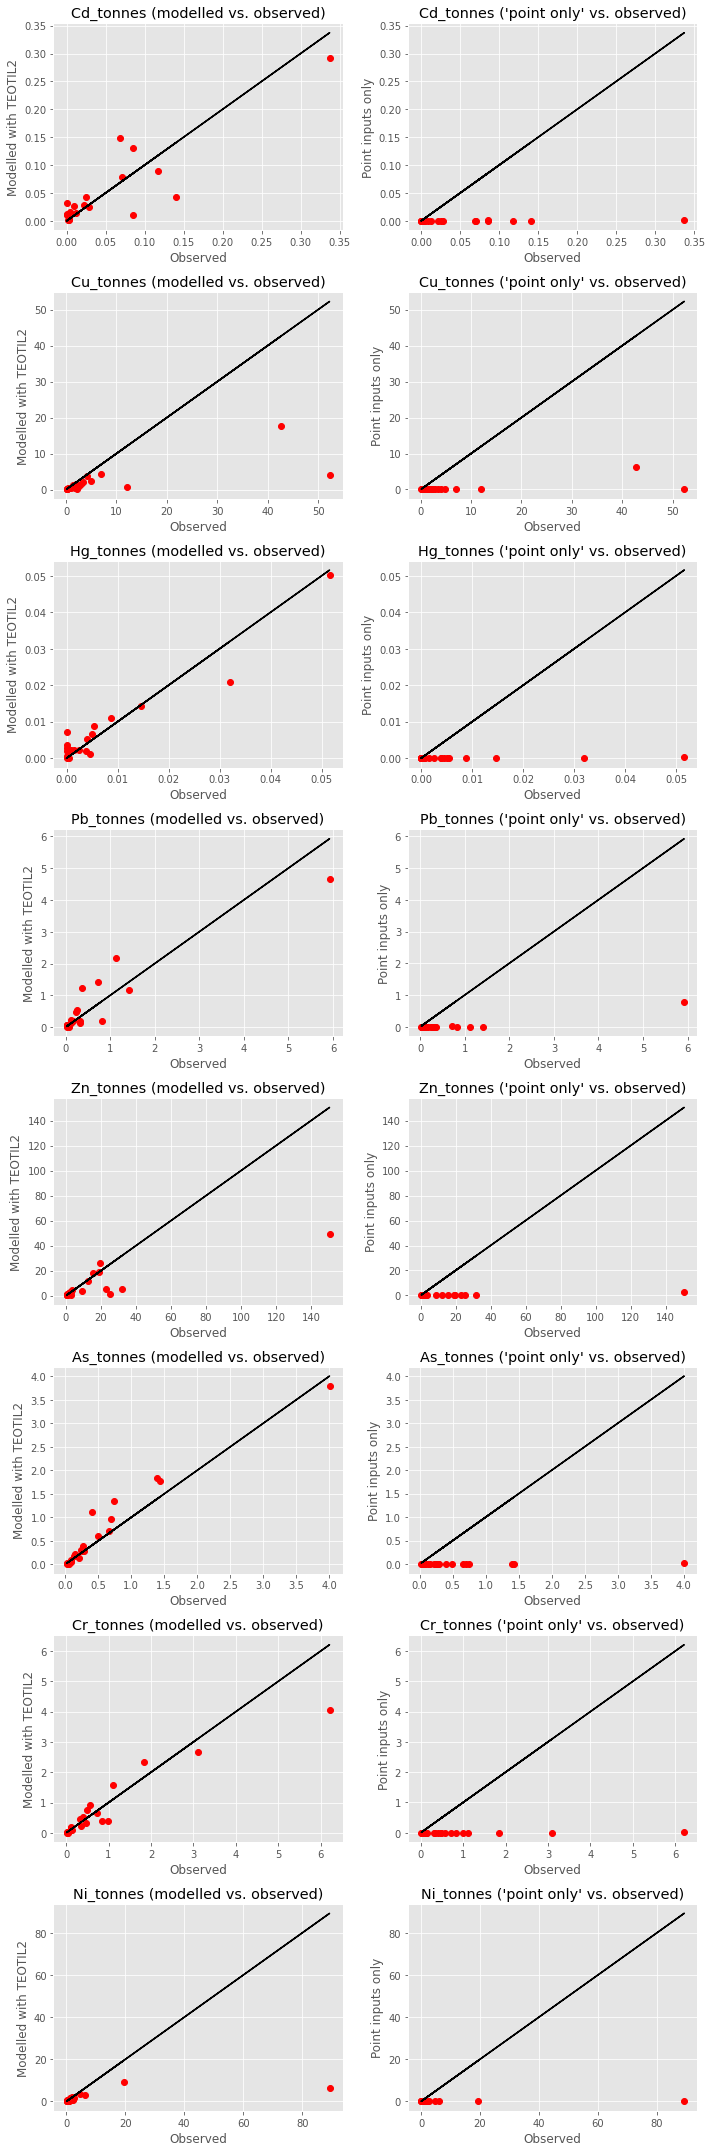

In [22]:
# Scatter plots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 30))

for idx, par in enumerate(sorted(df["variable"].unique())):
    par_df = df.query("variable == @par")

    axes[idx, 0].plot(par_df["observed"], par_df["teotil2"], "ro")
    axes[idx, 0].plot(par_df["observed"], par_df["observed"], "k-")
    axes[idx, 0].set_xlabel("Observed")
    axes[idx, 0].set_ylabel("Modelled with TEOTIL2")
    axes[idx, 0].set_title(f"{par.capitalize()} (modelled vs. observed)")

    axes[idx, 1].plot(par_df["observed"], par_df["point_only"], "ro")
    axes[idx, 1].plot(par_df["observed"], par_df["observed"], "k-")
    axes[idx, 1].set_xlabel("Observed")
    axes[idx, 1].set_ylabel("Point inputs only")
    axes[idx, 1].set_title(f"{par.capitalize()} ('point only' vs. observed)")

plt.tight_layout()

png_path = f"../plots/metals/1k_lakes/teotil2_vs_point_only_scatter_{year}_n20p1.png"
plt.savefig(png_path, dpi=300, bbox_inches="tight")

"Target plots", such as those shown below, are a convenient way of summarising model performance. **Better models plot closer to the centre of the target**. The following is taken from the NivaPy "docstring":

>Target plot comparing normalised bias and normalised, unbiased RMSD between two datasets (usually modelled versus observed). Based on code written by Leah Jackson-Blake for the REFRESH project and described in the REFRESH report as follows:
>    
>    "The y-axis shows normalised bias between simulated and observed. The 
>     x-axis is the unbiased, normalised root mean square difference (RMSD) 
>     between simulated and observed data. The distance between a point and the
>     origin is total RMSD. RMSD = 1 is shown by the solid circle (any point 
>     within this has positively correlated simulated and observed data and 
>     positive Nash Sutcliffe scores); the dashed circle marks RMSD = 0.7 (the 
>     area within this is approximately equal to the area of the outer "donut"). 
>     Normalised, unbiased root mean squared deviation is a useful way of 
>     comparing standard deviations of the observed and modelled datasets."
>
>See Joliff et al. (2009) for full details:
>
>    https://www.sciencedirect.com/science/article/pii/S0924796308001140

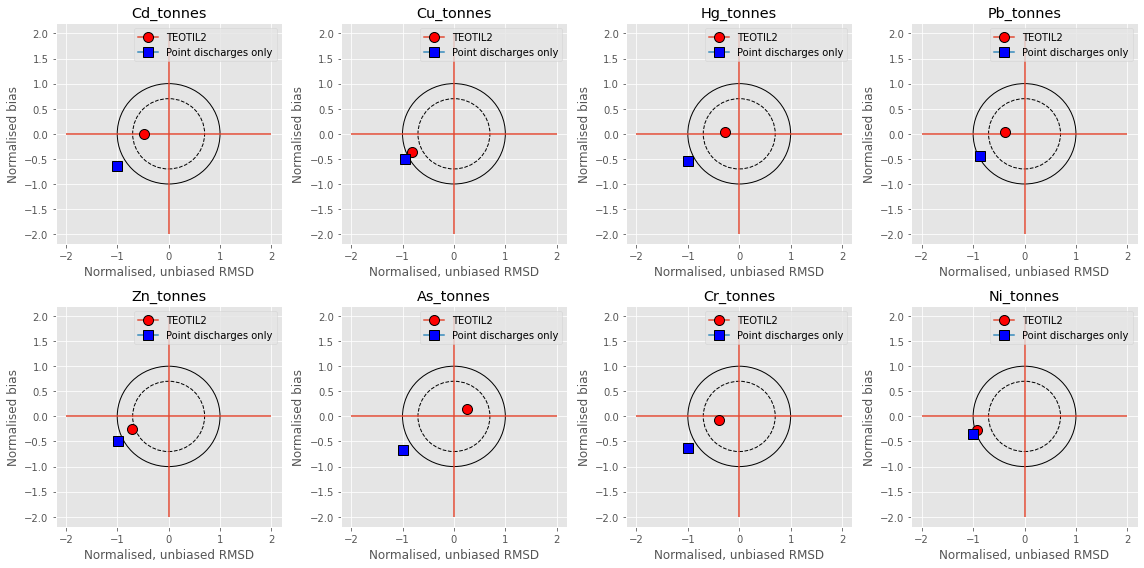

In [23]:
# Target plots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()

for idx, par in enumerate(sorted(df["variable"].unique())):
    par_df = df.query("variable == @par")

    nivapy.plotting.target_plot(
        mod_list=[par_df["teotil2"], par_df["point_only"]],
        obs_list=[par_df["observed"], par_df["observed"]],
        labels=["TEOTIL2", "Point discharges only"],
        markers=["o", "s"],
        colours=["r", "b"],
        ax=axes[idx],
        title=par.capitalize(),
    )

plt.tight_layout()

png_path = f"../plots/metals/1k_lakes/teotil2_vs_point_only_target_{year}_n20p1.png"
plt.savefig(png_path, dpi=300, bbox_inches="tight")

In [24]:
# OLS linear regression
data_dict = {
    "par": [],
    "slope": [],
    "R2": [],
    "pval": [],
}
for idx, par in enumerate(sorted(df["variable"].unique())):
    par_df = df.query("variable == @par")

    mod = smf.ols(formula="observed ~ teotil2 - 1", data=par_df)
    res = mod.fit()

    data_dict["par"].append(par)
    data_dict["slope"].append(res.params[0])
    data_dict["R2"].append(res.rsquared)
    data_dict["pval"].append(res.pvalues[0])

    print(
        f"\n###############################################################################################"
    )
    print(f"# {par.capitalize()}\n")
    print(res.summary())
    print(
        f"\n###############################################################################################\n"
    )

res_df = pd.DataFrame(data_dict)


###############################################################################################
# Cd_tonnes

                                 OLS Regression Results                                
Dep. Variable:               observed   R-squared (uncentered):                   0.837
Model:                            OLS   Adj. R-squared (uncentered):              0.829
Method:                 Least Squares   F-statistic:                              97.78
Date:                Fri, 13 Nov 2020   Prob (F-statistic):                    6.31e-09
Time:                        13:01:29   Log-Likelihood:                          37.237
No. Observations:                  20   AIC:                                     -72.47
Df Residuals:                      19   BIC:                                     -71.48
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
          

In [25]:
# Results summary
res_df

,par,slope,R2,pval
0,cd_tonnes,0.997389,0.837295,6.306482e-09
1,cu_tonnes,2.785095,0.611679,2.809121e-05
2,hg_tonnes,1.044751,0.942173,3.226722e-13
3,pb_tonnes,1.055328,0.887407,1.860232e-10
4,zn_tonnes,2.244156,0.788180,7.939944e-08
5,as_tonnes,0.899168,0.951179,6.433749e-14
6,cr_tonnes,1.229343,0.922612,5.188357e-12
7,ni_tonnes,4.947584,0.466754,6.410261e-04


## 9. Summary

It is clear from the plots above that TEOTIL2 Metals implemented using the 2019 1000 Lakes dataset is substantially better than the current "default" workflow of only reporting point discharges: scatter plots for the new model show clear positive correlations for most metals, with slopes that are close to 1 in five out of eight cases. By contrast, using only point discharges dramatically underestimates observed fluxes (unsurprisingly). The target plots also clearly illustrate the improved performance of the new model.

Interestingly, both sets of plots show the new model consistently *underestimates* metal fluxes (although not by much compared to the old method): estimated OLS regression slopes are consistently greater than 1, and **a bias-correction factor of about 1.2 might be generally appropriate for the spatially interpolated 1000 Lakes dataset**. For Ni and Cu in particular, fluxes estimated for the largest rivers are very low, which implies either (i) mean metal concentrations estimated from the 1000 Lakes dataset do not accurately represent mean "diffuse-source" concentrations in these catchments, or (ii) we are missing some substantial inputs from point sources (e.g. industry) in these catchments.

These issues require further investigation but, for the moment, **I believe the tests presented here using independent observed data justify further development of this approach**.